In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv
import pandas as pd
import numpy as np
import itertools
import collections 
from scipy import stats
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import matplotlib.artist as artists
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from lmfit import Model
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as mcolors
from figure_dict import *

%matplotlib inline 
plt.style.use('figures')

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#input
fin = "output/Thermalmelt/Thermalmelt-Tm.csv"
tm = pd.read_csv(fin)

fin = "output/CD-titration/Titration-ddG.csv"
dG = pd.read_csv(fin)

fin = "output/CD-spectra/CD-spectra-30C-percentWTsignal.csv"
cd = pd.read_csv(fin)
cd["MRE222norm"] = cd["222"]/cd.loc[0,"222"]

fin = "output/GrowthAssay/selecoeff_relprotconc.csv"
conc = pd.read_csv(fin)

fin = "output/Function/Function-all-table.csv"
act = pd.read_csv(fin)

df = conc.set_index('Protein').join(cd.set_index('Protein'), how = "inner")
df = df.join(dG.set_index('Protein'), how = "inner")
df = df.join(tm.set_index('Protein'), how = "inner")
df = df.join(act.set_index('Protein'), how = "inner")
#df.rename(columns={'kcat/km (uM-1*s-1)': 'keff'}, inplace=True)
df["eff_func_cap"] = df["RelativeProteinConc"]*df["kcat/km (uM-1*s-1)"]
df["eff_func_cap_ddGKm"] = df["RelativeProteinConc"]*df["ddG_Km (kcal/mol)"]
df["eff_func_cap_ddGKcat"] = df["RelativeProteinConc"]*df["ddG_kcat (kcal/mol)"]
df["eff_func_cap_ddGkeff"] = df["RelativeProteinConc"]*df["ddG_keff (kcal/mol)"]
df["color_p"] = pd.Series(colordictFit)

df = df.fillna(value=0);
df.head()

,Fitness,Fitness_err,SeleCoef,SeleCoef_err,RelativeProteinConc,RelativeProteinConc_err,color_p,label_p,222,PercentWT,...,interaction_Km (kcal/mol),interaction_kcat (kcal/mol),interaction_keff (kcal/mol),interaction_Km_err (kcal/mol),interaction_kcat_err (kcal/mol),interaction_keff_err (kcal/mol),eff_func_cap,eff_func_cap_ddGKm,eff_func_cap_ddGKcat,eff_func_cap_ddGkeff
Protein,,,,,,,,,,,,,,,,,,,,,
SsWT,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,"(0.898039215686, 0.847058823529, 0.81960784313...",SsWT,-8.145983,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.026380,0.000000,0.000000,0.000000
I45A,1.019224,0.012183,0.020071,0.012728,1.078934,0.211498,"(0.898039215686, 0.847058823529, 0.81960784313...",I45A,-7.950954,0.976058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.026502,0.183419,0.230892,0.043157
I45K,1.165507,0.011608,0.172799,0.012240,2.019055,0.435368,"(0.8, 0.250980392157, 0.227450980392, 1.0)",I45K,-8.452485,1.037626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.058930,-0.020191,-0.137296,-0.121143
S70A,0.997166,0.011746,-0.002959,0.012262,0.994272,0.216237,"(0.83137254902, 0.858823529412, 0.901960784314...",S70A,-8.452386,1.037614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.027987,0.017897,-0.017897,-0.039771
M73A,0.888372,0.009969,-0.116546,0.010389,1.006651,0.217051,"(0.482352941176, 0.623529411765, 0.97647058823...",M73A,-7.587563,0.931448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009251,-0.040266,0.606004,0.634190


In [4]:
df = df.replace(regex=r'\r', value='')

In [5]:
def autolabel(p, x, y, ax, intercept, slope, minx, maxx):
    #get order of magnitude
    ordermag = pow(10, (math.ceil(math.log10((max(y))))))
    y_shift = ordermag/10 * 0.05
    for prot, x_val, y_val in zip(p, x, y):
        ypred = intercept+slope*x_val
        
        if (y_val > ypred or y_val == 0):
            if prot =="I45A\nS70A" or prot =="I45K\nS70A":
                ax.text(x_val, y_val-y_shift, prot, ha='center', va='top', size=14)
            else:
                ax.text(x_val, y_val+y_shift, prot, ha='center', va='bottom', size=14)
        else: 
            ax.text(x_val, y_val-y_shift, prot, ha='center', va='top', size=14)
    return

def scatter(df, ax, x_col, y_col, order):
    
    wt_x = df.get_value("SsWT", x_col)
    wt_y = df.get_value("SsWT", y_col)    
    temp = df.sort_values(by = [x_col])
    x = temp[x_col]
    y = temp[y_col]
    col_p = temp["color_p"]    
    lab_p = temp["label_p"]

    #SsWT guidelines
    ax.axvline(x=wt_x, color = "grey", linestyle = ":", zorder=0)
    ax.axhline(y=wt_y, color = "grey", linestyle = ":", zorder=0)
    
    #scatter plot of data
    ax.scatter(x, y, c= col_p ,  marker="o", s=120, linewidth='0.5', label='_nolegend_', zorder=2)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    autolabel(lab_p, x, y, ax, intercept, slope, min(x), max(x))
    
    #set plot axes 

    xpadding = max(x) * 0.1
    ypadding = max(y) * 0.2
    xminplot = min(x)-xpadding
    xmaxplot = max(x)+xpadding
    yminplot = min(y)-ypadding
    ymaxplot = max(y)+ypadding
    ax.set_xlim([xminplot,xmaxplot])
    ax.set_ylim([yminplot,ymaxplot])

    #single exponential fit
    X = np.vander(x, 2)
    model1 = sm.OLS(y,X)
    results1 = sm.OLS(y,X).fit()
    #extend fit to x-axis limit
    xx = np.linspace(xminplot, xmaxplot, 120)
    XX = np.vander(xx, 2)
    ax.plot(xx, results1.predict(XX), 'k--', label='_nolegend_', alpha=0.9, zorder=1)
    r_value = math.sqrt( results1.rsquared)
    xax_range = max(x)-min(x) #axesdict2D[x_col][1]-axesdict2D[x_col][0]
    yax_range = max(y)-min(y) #axesdict2D[y_col][1]-axesdict2D[y_col][0]

    if (slope < 0):
        if xmaxplot >= 0:
            ax.text(xmaxplot*0.9, ymaxplot*.9, u'$R= %.2f$' % r_value, ha='right', va='center', color= 'r', size=25)
        else:
            ax.text(xmaxplot*-0.2, ymaxplot*.9, u'$R= %.2f$' % r_value, ha='right', va='center', color= 'r', size=25)
    else: 
        if xminplot >= 0:
            ax.text(xminplot*1.1, ymaxplot*0.9, u'$R= %.2f$' % r_value, ha='left', va='center', color= 'r', size=25)
        else:
            ax.text(xminplot*0.9, ymaxplot*0.9, u'$R= %.2f$' % r_value, ha='left', va='center', color= 'r', size=25)
    lgd = ax.legend(loc = "best")
        #lgd.get_frame().set_linewidth(0.0)
    ax.tick_params(axis='both') 
    
    return

def createGraph2(xycombo, analysis, order):
    #always use 2 columns
    num_row = len(xycombo)
    num_col = 1
    fig = plt.figure(figsize=(figsize["Height"],figsize["Double"])) 
    gs = gridspec.GridSpec(nrows=num_row, ncols=num_col)

    for i, xy in enumerate (xycombo):
        x_col = str(xy[0])
        y_col = str(xy[1])
        if x_col in labeldict.keys():
            x_label = labeldict[x_col] 
        else: 
            x_label = ""
        if  y_col in labeldict.keys():
            y_label = labeldict[y_col]
        else:
            y_label = ""
        ax = plt.subplot(gs[i])
        fig_subtitle = y_label + " vs " + x_label
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        scatter(df, ax, x_col, y_col, order)

    ## red to blue colorbar
    cmap = mpl.cm.get_cmap("coolwarm")
    norm = mpl.colors.Normalize(vmin= -0.2, vmax=0.2)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array([])
    cbar = plt.colorbar(m)
    cbar.set_label('s', rotation=90,labelpad=10)
    
    fig.tight_layout()
    #plt.subplots_adjust(hspace=0.25)
    fig.subplots_adjust(top = .95)
    return fig


## Figure 6 - a ##

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


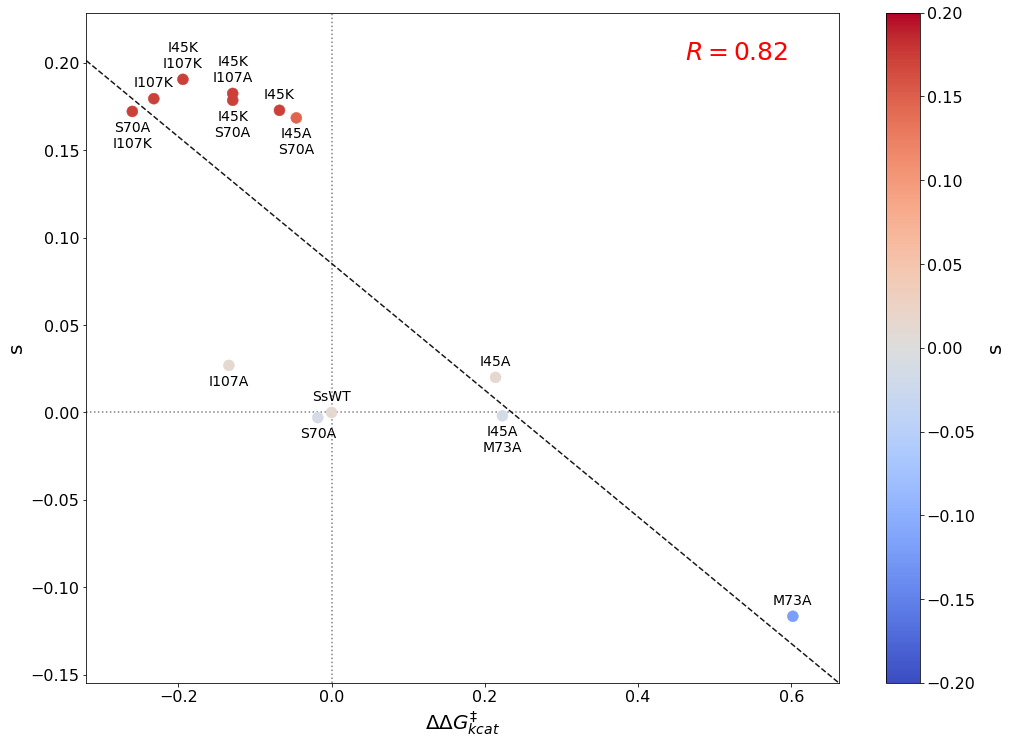

In [6]:
analysis = 's_vs_function'
fout = "output/Analysis/"+analysis+".pdf"

#a = [["ddG_Km (kcal/mol)","ddG_kcat (kcal/mol)", "ddG_keff (kcal/mol)"],["SeleCoef"]]
a = [["ddG_kcat (kcal/mol)"],["SeleCoef"]]
xycombo = list(itertools.product(*a))

#creates 2x2 panel of scatter plots 
fig = createGraph2(xycombo, analysis, order = 1)
fig.show()
#print fout
fig.savefig(fout)